# Importing Essential Libraries

In [69]:
import pandas as pd        # For data manipulation and reading CSV/tabular data
from sklearn.model_selection import train_test_split # To split data into Train and Test sets

import torch               # The core PyTorch library
import torch.nn as nn      # Contains Building blocks for Neural Networks (Layers, Loss functions)
from torch.utils.data import Dataset, DataLoader # Tools to manage and batch your data

import torch.optim as optim  # Corrected: Contains optimization algorithms like SGD and Adam
import matplotlib.pyplot as plt # For plotting loss curves and accuracy

In [70]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Loading and Visualizing the dataset

In [71]:
df = pd.read_csv("fmnist_small.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,...,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,120,108,0,0,4,6,11,17,80,24,224,30,0,0,0,0,0,...,224,237,0,0,0,0,0,30,109,199,243,255,255,251,242,236,230,246,228,0,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,202,213,210,205,204,221,157,172,131,55,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5,0,77,157,148,155,146,151,149,152,154,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,47,136,31,136,42,0,3,0,0,0,0,0,0,0,0,0,0,0,...,204,199,197,94,0,3,0,9,164,152,138,152,160,152,162,144,208,181,1,18,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,29,132,0,0,101,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,18,134,155,178,149,163,165,138,147,170,149,134,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0


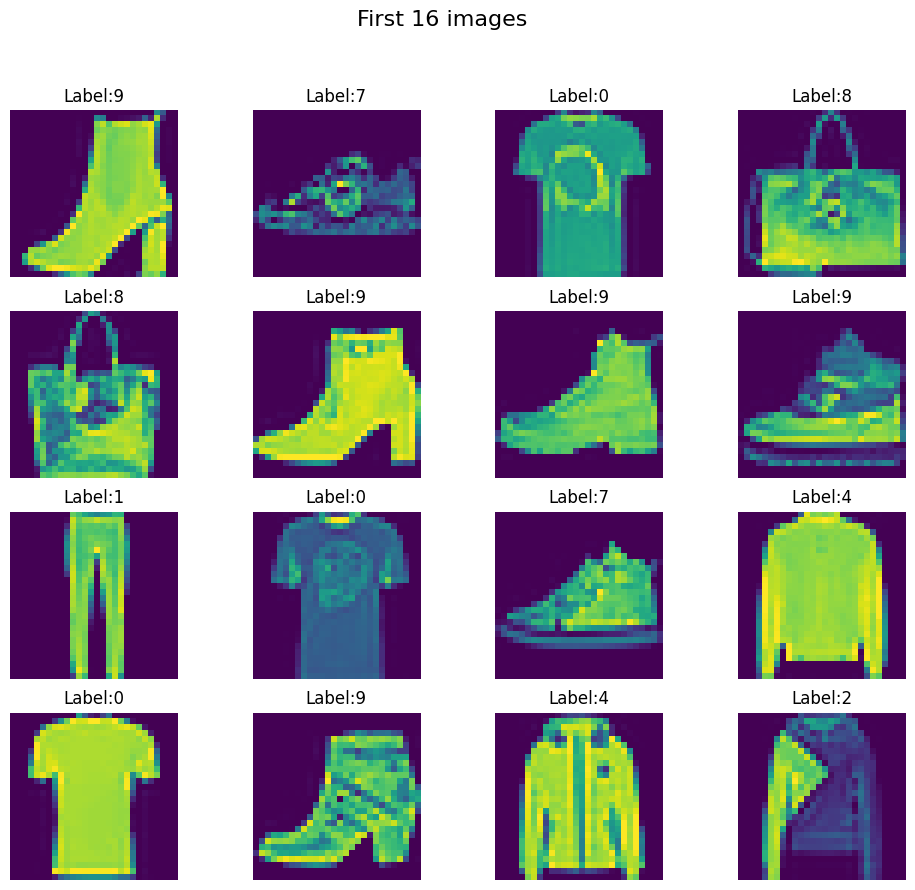

In [72]:
# create a 4x4 grid
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
fig.suptitle("First 16 images", fontsize=16)

# ploting
for i,ax in enumerate(ax.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label:{df.iloc[i,0]}")

# adjust layout to fit the title
# plt.tight_layout(rect=[0,0,1,1.96])
plt.show()

# Spliting data and basic preprocessing

In [73]:
x=df.iloc[:,1:].values
y=df.iloc[:,0].values

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.25, random_state=42)

print(f"xtrain shape:{xtrain.shape}")
print(f"xtest shape:{xtest.shape}")
print(f"ytrain shape:{ytrain.shape}")
print(f"ytest shape:{ytest.shape}")

xtrain shape:(4500, 784)
xtest shape:(1500, 784)
ytrain shape:(4500,)
ytest shape:(1500,)


In [74]:
# scaling the features
xtrain = xtrain / 255.0
xtest = xtest / 255.0

xtest[0,400:500]

array([0.83921569, 0.80784314, 0.83921569, 0.85882353, 0.86666667,
       0.85098039, 0.76862745, 0.83529412, 0.95686275, 0.92941176,
       0.8627451 , 0.87843137, 0.87843137, 0.85882353, 0.84705882,
       0.85490196, 0.86666667, 0.84313725, 0.88235294, 0.66666667,
       0.02352941, 0.67058824, 0.85882353, 0.85882353, 0.86666667,
       0.85098039, 0.81176471, 0.78823529, 0.80392157, 0.82352941,
       0.83137255, 0.84313725, 0.85098039, 0.85882353, 0.89411765,
       0.89019608, 0.88627451, 0.89019608, 0.90980392, 0.90196078,
       0.90980392, 0.94117647, 0.92941176, 0.91764706, 0.93333333,
       0.90980392, 0.95294118, 0.79215686, 0.25882353, 0.8627451 ,
       0.90196078, 0.90980392, 0.90980392, 0.90980392, 0.90980392,
       0.89803922, 0.90588235, 0.92941176, 0.92941176, 0.9254902 ,
       0.9372549 , 0.9372549 , 0.9254902 , 0.9254902 , 0.99607843,
       0.99607843, 0.98823529, 0.96078431, 0.92156863, 0.90980392,
       0.8745098 , 0.8627451 , 0.82745098, 0.72156863, 0.73725

# Creating CustomDataset Class

In [75]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [76]:
# creating train and test dataset object
train_dataset = CustomDataset(xtrain, ytrain)
test_dataset = CustomDataset(xtest, ytest)

In [77]:
# Creating train test loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building ANN

## Define Neural Network Class

In [78]:
class myNN(nn.Module):
    def __init__(self, num_features):
        """
        Constructor: Define the layers of the network here.
        num_features: The number of input pixels (e.g., 784 for a 28x28 image).
        """
        super().__init__() # Initializes the parent nn.Module class
        
        # nn.Sequential groups layers together so they execute in order
        self.model = nn.Sequential(
            # Input Layer: Takes 784 features and expands/reduces to 128 neurons
            nn.Linear(num_features, 128),
            # Activation Function: Replaces all negative values with 0
            # This allows the model to learn non-linear patterns.
            nn.ReLU(),
            
            # Hidden Layer: Takes 128 inputs and reduces to 64
            nn.Linear(128, 64),
            nn.ReLU(),
            
            # Output Layer: 10 neurons (one for each digit 0-9)
            # We don't use Softmax here because nn.CrossEntropyLoss does it for us!
            nn.Linear(64, 10)
        )

    def forward(self, x):
        """
        The Forward Pass: Defines how the data 'x' moves through the layers.
        """
        return self.model(x)

## set Learning_rate and epoch

In [79]:
epochs = 100
Learning_rate = 0.001

## Instatite the model

In [80]:
model = myNN(xtrain.shape[1])

## Define Lossfunction 

In [81]:
Lossfunction = nn.CrossEntropyLoss()

## Define Optimizer 

In [82]:
optimzer = optim.Adam(model.parameters(), lr = Learning_rate)

## Training Loop

In [83]:
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_label in train_loader:
        # forword pass
        outputs = model(batch_features)
        
        # calcluate loss
        loss = Lossfunction(outputs, batch_label)
        
        # back prop
        optimzer.zero_grad()
        loss.backward()
        
        # upgrade grads
        optimzer.step()

        total_epoch_loss = total_epoch_loss + loss.item()
    # priniting the avrage loss per epoch
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch: {epoch+1} , Loss: {avg_loss} , total_epoch_loss:{total_epoch_loss}" )

Epoch: 1 , Loss: 1.0674212953300342 , total_epoch_loss:150.5064026415348
Epoch: 2 , Loss: 0.6263590281736766 , total_epoch_loss:88.3166229724884
Epoch: 3 , Loss: 0.5446014624115423 , total_epoch_loss:76.78880620002747
Epoch: 4 , Loss: 0.4909841525005111 , total_epoch_loss:69.22876550257206
Epoch: 5 , Loss: 0.447250967647167 , total_epoch_loss:63.06238643825054
Epoch: 6 , Loss: 0.4229641061091254 , total_epoch_loss:59.63793896138668
Epoch: 7 , Loss: 0.38753615330297053 , total_epoch_loss:54.64259761571884
Epoch: 8 , Loss: 0.3493119754055713 , total_epoch_loss:49.252988532185555
Epoch: 9 , Loss: 0.3376448746797041 , total_epoch_loss:47.607927329838276
Epoch: 10 , Loss: 0.3304021475797004 , total_epoch_loss:46.586702808737755
Epoch: 11 , Loss: 0.29302371335579147 , total_epoch_loss:41.3163435831666
Epoch: 12 , Loss: 0.2912508623661302 , total_epoch_loss:41.06637159362435
Epoch: 13 , Loss: 0.2778123011086004 , total_epoch_loss:39.171534456312656
Epoch: 14 , Loss: 0.257418378077923 , total_

## set model to eval mode

In [84]:
model.eval()

myNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

## Evaluation Code

In [95]:
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        output = model(batch_features)
        _, predicted = torch.max(output,1)
        total = total + batch_labels.shape[0]
        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.842
